In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import integrate
import pandas as pd
from functools import partial
import models

# iARD-RSC Model
$$
\begin{equation}\tag{1}
\mathbf{\dot{A}}=\mathbf{\dot{A}}^{HD}+\mathbf{\dot{A}}^{iARD}+\mathbf{\dot{A}}^{RSC}
\end{equation}
$$
- HD term (Hydro dynamic term, or Jeffrey term):
$$
\begin{equation}\tag{2}
\mathbf{\dot{A}}=\mathbf{W\cdot A}-\mathbf{A\cdot W}+\xi(\mathbf{D\cdot A}+\mathbf{A\cdot D}-2\mathbf{A:D})
\end{equation}
$$
- iARD term (Ref: Tseng, H.-C. et. al. _J. Rheol._ **2016**, 60, 215–224.):  
$$
\begin{equation}\tag{3}
\begin{aligned}
\mathbf{\dot{A}}^{iARD}&=+2|\dot{\gamma}|\left(\mathbf{I}-\mathbf{pp}\right)\cdot\mathbf{D}_r\cdot\left(\mathbf{I}-\mathbf{pp}\right)\cdot\left(\mathbf{I}-3\mathbf{A}\right)\\
where \quad
\mathbf{D}_r&=C_I\left(\mathbf{I}-C_M\frac{\mathbf{D}^2}{||\mathbf{D}^2||}\right)
\end{aligned}
\end{equation}
$$
- RSC term (Ref: Wang, J. et. al. _J. Rheol._ **2008**, 52, 1179–1200.): 
$$
\begin{equation}\tag{4}
\begin{aligned}
\mathbf{\dot{A}}^{RSC}&=-(1-\kappa)\sum^3_{i=1}\dot{\lambda}_i^{IRD/iARD}\mathbf{e}_i\mathbf{e}_i\\
where \quad
\mathbf{q}&=\sum^3_{i=1}\beta_i(\mathbf{e}_i\mathbf{e}_i\cdot\mathbf{p}-\mathbf{e}_i\mathbf{e}_i:\mathbf{ppp})\\
and \quad
\beta_i&=-\frac{5(1-\kappa)}{4\pi}\left[\xi(\lambda_i\mathbf{D}:\mathbf{e}_i\mathbf{e}_i-\mathbf{e}_i\mathbf{e}_i:\mathbf{A}_4:\mathbf{D})+C_I\dot\gamma(1-3\lambda_i)\right]
\end{aligned}
\end{equation}
$$

# iARD-RSC Model Under Simple Shear

<Axes: title={'center': 'iARD-RSC model under simple shear'}, xlabel='Time (s)', ylabel='$\\mathbf{A}$ componenets'>

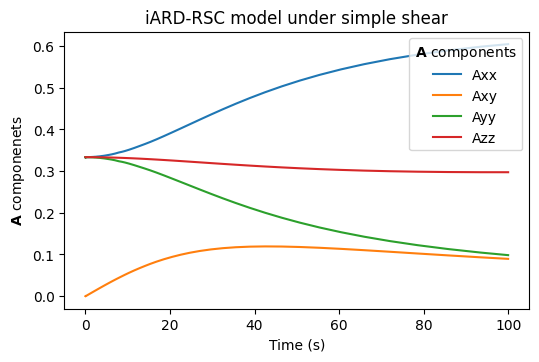

In [2]:
##########################################################
#parameters
CI=0.1
CM=1
rho=10
kappa=0.03
shear_rate=1
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=shear_rate
#for simple shear, initial state is random oriented
a2_0=np.eye(3)/3
########################################################
#ODE function
fun=partial(models.iARD_RSC.ode_fun,CI=CI,CM=CM,kappa=kappa,L=L,rho=rho)
res=integrate.solve_ivp(fun,(0,100),a2_0.reshape((-1,)),method='RK45')
res_df=pd.DataFrame(res.y.T,index=res.t,columns=['Axx','Axy','Axz',\
                                                'Ayx','Ayy','Ayz',\
                                                'Azx','Azy','Azz'])
res_df.index.name='time(s)'
res_df.columns.name=r'$\mathbf{A}$ components'
res_df.plot(y=['Axx','Axy','Ayy','Azz'],title='iARD-RSC model under simple shear',figsize=(6,3.6), \
            xlabel="Time (s)", ylabel = r"$\mathbf{A}$ componenets")

# Calculate stress for various fiber contents

<Axes: xlabel='Strain ()', ylabel='Nornal Stress (Pa)'>

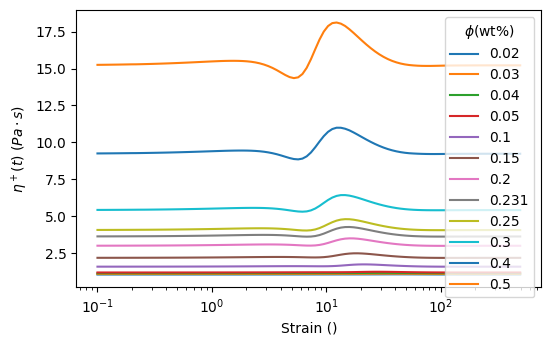

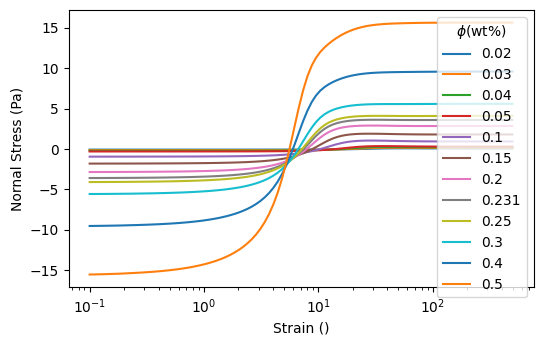

In [3]:
def cal_stress(a2_0,phi,strain,viscosity_0=1,shear_rate=1):
    L=np.zeros((3,3),dtype=np.float64)
    L[0,1]=shear_rate
    rho=32
    CI=0.03*(1-np.exp(-0.224*rho*phi))
    fun=partial(models.iARD_RSC.ode_fun,CI=CI,CM=0,kappa=0.1,L=L,rho=rho)
    t_span=(0,strain/shear_rate)
    t_eval=np.logspace(-1,np.log10(t_span[1])*0.999,num=100)
    res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='LSODA',t_eval=t_eval)
    res_df=pd.DataFrame(res.y.T,index=res.t*shear_rate)
    res_df.index.name=r'Strain ()'
    for ind,row in res_df.iterrows():
        a2=np.reshape(row.values[:9],[3,3])
        #a4=models.a4_IBOF.a4_IBOF(a2)
        a4=models.a4_ORW3.a4_ORW3(a2)
        sigma=models.stress_Lipscomb.stress_Lipscomb(viscosity_0,L=L,rho=rho,a2=a2,phi=phi)
        res_df.loc[ind,'viscosity(Pa.s)']=sigma[0,1]/shear_rate
        res_df.loc[ind,'N1(Pa)']=sigma[0,0]-sigma[1,1]
        res_df.loc[ind,'N2(Pa)']=sigma[1,1]-sigma[2,2]
        res_df.loc[ind,'N1-N2']=sigma[0,0]+sigma[2,2]-2*sigma[1,1]
        res_df.loc[ind,'s11']=sigma[0,0]
        res_df.loc[ind,'s12']=sigma[0,1]
        res_df.loc[ind,'s13']=sigma[0,2]
        res_df.loc[ind,'s22']=sigma[1,1]
        res_df.loc[ind,'s23']=sigma[1,2]
        res_df.loc[ind,'s33']=sigma[2,2]
    return res_df
viscosity_res_df=pd.DataFrame()
normal_res_df=pd.DataFrame()
for wt_phi in [0.02,0.03,0.04,0.05,0.1,0.15,0.20,0.231,0.25,0.3,0.4,0.5]:
    phi=wt_phi/2.7/(1-wt_phi+wt_phi/2.7)
    #forward shear
    a2_0=np.eye(3)/3
    res_df_forward=cal_stress(a2_0=a2_0,phi=phi,strain=500)
    #reversal shear
    a2_0_reversal=np.copy(np.reshape(res_df_forward.iloc[-1,:9].values,[3,3]))
    a2_0_reversal[0,1]=-a2_0_reversal[0,1]
    a2_0_reversal[1,0]=-a2_0_reversal[1,0]
    res_df_reversal=cal_stress(a2_0=a2_0_reversal,phi=phi,strain=500)
    #res_df_reversal.plot(y=['s12','N1(Pa)','N2(Pa)','N1-N2'],logx=True)
    viscosity_res_df.loc[:,wt_phi]=res_df_reversal.loc[:,'viscosity(Pa.s)']
    normal_res_df.loc[:,wt_phi]=res_df_reversal.loc[:,'N1-N2']
viscosity_res_df.columns.name=r"$\phi$(wt%)"
viscosity_res_df.plot(logx=True,figsize=(6,3.6),ylabel=r"$\eta^+(t)\ (Pa\cdot s)$")
normal_res_df.columns.name=r"$\phi$(wt%)"
normal_res_df.plot(logx=True,figsize=(6,3.6),ylabel="Nornal Stress (Pa)")